# sequence prediction sandbox


In [1]:
import torch
from torch.utils.data import TensorDataset,DataLoader
from torch import nn

import logomaker
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7) #10

import utils as u

## Load data 

In [2]:
def load_data(
        upstream_region_file,
        data_mat_file, 
        sample2cond_file, 
        sample_file, 
        condition_file,
        coded_meta_file
        ):
    '''
    Wrapper function to load data from files into relavent objects
    '''
    # load upstream seq regions
    seqs = u.load_promoter_seqs(upstream_region_file)
    loc2seq = dict([(x,z) for (x,y,z) in seqs])
    
    # load TPM data
    tpm_df = pd.read_csv(data_mat_file,sep='\t').fillna('')

    
    # load mapping from sample to condition
    with open(sample2cond_file,'r') as f:
        sample2condition = dict(x.strip().split() for x in f.readlines())

    
    # load sample to include file
    if sample_file:
        with open(sample_file,'r') as f:
            samples = list(x.strip() for x in f.readlines())
    # if none provided, just use all the samples from the sample2condition dict
    else: 
        samples = list(sample2condition.keys())

        
    # load the conditions to include file
    if condition_file:
        with open(condition_file,'r') as f:
            conditions = list(x.strip() for x in f.readlines())
    # if none provided, just use all the conditions
    else:
        conditions = list(set([sample2condition[x] for x in sample2condition]))

    # load coded metadata file
    meta_df = pd.read_csv(coded_meta_file,sep='\t')
    meta_df['sample'] = meta_df['#sample']+'_tpm'

    return loc2seq, tpm_df, sample2condition, samples, conditions, meta_df

In [3]:
upstream_region_file = 'all_seq_info/all_loci_upstream_regions_w100_min20.fa'
data_mat_file = 'data/extract_TPM_counts.tsv'
sample2cond_file = 'data/sample2condition.txt'
sample_file = None
condition_file = 'data/conditions_to_include.txt'
coded_meta_file = 'data/5G_exp_metadata_coded.tsv'
COND_COLS = ['carbon_source','oxygen_level','nitrate_level','copper_level','lanthanum_level','growth_rate','growth_mode']


loc2seq, tpm_df, sample2condition, samples, conditions, meta_df = load_data(
    upstream_region_file,
    data_mat_file, 
    sample2cond_file, 
    sample_file, 
    condition_file,
    coded_meta_file
)

In [4]:
def format_XY_dfs(tpm_df, meta_df):
    # melt tpm df so every sample is in a row
    tpm_melt = tpm_df[['locus_tag']+samples].melt(id_vars=['locus_tag'],var_name='sample',value_name='tpm')
    tpm_melt['condition'] = tpm_melt['sample'].apply(lambda x: sample2condition[x])

    # also add in upstream seq
    tpm_melt['upstream_region'] = tpm_melt['locus_tag'].apply(lambda x: loc2seq[x])
    
    # get coded metadata conditions from meta_df
    samp2cond_df = meta_df[['sample']+COND_COLS]

    # merge back onto the tpm df
    df = tpm_melt.merge(samp2cond_df,on='sample',how='left')
    
    # reformat full df
    full_df = df[['locus_tag','upstream_region', 'sample','condition']+COND_COLS+['tpm']]
    
    # separate out just X (features) and Y (labels)
    X = full_df[['locus_tag','upstream_region']+COND_COLS]
    Y = full_df['tpm']
    
    return full_df,X,Y
    

In [5]:
full_df, X, Y = format_XY_dfs(tpm_df,meta_df)

In [6]:
full_df

,locus_tag,upstream_region,sample,condition,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,tpm
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,2.933003
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.607784
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.415515
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,3.200081
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.522728
...,...,...,...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,24.508375
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,130.851229
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,66.415222
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,164.123473


In [7]:
X

,locus_tag,upstream_region,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,2,0,0,3,0,0,0
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,2,0,0,3,0,0,0
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,2,0,0,3,0,0,0
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,2,0,0,3,0,0,0
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,2,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,2,1,0,3,0,2,1
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,2,1,0,3,0,2,1
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,2,1,0,3,0,2,1
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,2,1,0,3,0,2,1


In [8]:
Y

0           2.933003
1           1.607784
2           1.415515
3           3.200081
4           1.522728
             ...    
412869     24.508375
412870    130.851229
412871     66.415222
412872    164.123473
412873    301.751157
Name: tpm, Length: 412874, dtype: float64

In [9]:
def one_hot_encode(seq):
    #print("one hot encoding...")
    
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Creat empty matrix.
    #vec=torch.tensor([nuc_d[x] for x in seq])
    vec=np.array([nuc_d[x] for x in seq]).flatten()
        
    return vec

In [10]:
#tl_lin, vl_lin = fit(50, model_lin, loss_func, optimizer, train_dl, test_dl)

In [11]:
def quick_load_and_split_input(data, split_frac=0.8, verbose=False):
    '''
    Given a list of tuples, build a df, ohe the sequences, and randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    
    Return pytorch tensors of x/y train/test
    '''
    # convert data to df and one-hot encode
    df = pd.DataFrame(data, columns = ['seq','score'])
    df['oh'] = df['seq'].apply(lambda x: one_hot_encode(x))

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]

    x_train = torch.tensor(list(train_df['oh'].values))
    y_train = torch.tensor(list(train_df['score'].values)).unsqueeze(1)
    x_test  = torch.tensor(list(test_df['oh'].values))
    y_test  = torch.tensor(list(test_df['score'].values)).unsqueeze(1)
    
    if verbose:
        print("Example train seq")
        plt.imshow(x_train[0].reshape((6, 4)), cmap="gray")
        plt.show()
        
        print(idxs)
        print("Train #:", len(train_idxs))
        print("Test #:", len(test_idxs))
        
        print("Y test:", y_test)
        
    return x_train, y_train, x_test, y_test

def build_dataloaders(data, batch_size=4):
    '''
    Given sets of x and y train and test, put into pytorch loaders
    '''
    x_train, y_train, x_test, y_test = quick_load_and_split_input(data, verbose=True)
    
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_ds = TensorDataset(x_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
    return train_dl, test_dl

In [12]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    loss = loss_func(model(xb.float()), yb.float())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [13]:
class DNA_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(24, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        return self.lin(xb)
    

    
class DNA_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        xb = xb.view(-1,6,4).permute(0,2,1) # reshape to 4bs x 4channel x 6len
        #print(xb)
        xb = self.conv_net(xb)
        return xb

In [14]:
def run_model(train_dl,test_dl, model, lr=0.01, epochs=50):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, val_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    return model, train_losses, val_losses


def run_linear_model(train_dl,test_dl, lr=0.01, epochs=50):
    '''Linear specific model runner'''
    model = DNA_Linear()
    
    return run_model(train_dl,test_dl, model)


def run_cnn_model(train_dl,test_dl, lr=0.01, epochs=50):
    '''CNN specific model runner'''
    model = DNA_CNN()
    return run_model(train_dl,test_dl, model)

In [15]:
def quick_loss_plot(data_label):
    '''Plot loss by epoch'''
    for data, label in data_label:
        plt.plot(data, label=label)
    plt.legend()
    plt.ylabel("MSE loss")
    plt.xlabel("Epoch")
    plt.show()
    
def quick_seq_pred(model, seqs):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna))
        pred = model(s.float())
        print(dna, pred.item())

## Fake data

Example train seq


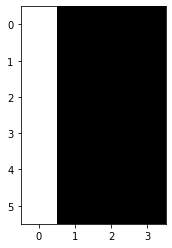

[22, 35, 14, 15, 10, 44, 11, 16, 43, 26, 38, 40, 31, 8, 0, 21, 19, 12, 24, 37, 45, 28, 36, 18, 1, 30, 17, 29, 7, 33, 39, 27, 5, 2, 13, 32, 42, 23, 6, 34, 4, 3, 41, 25, 9, 20]
Train #: 36
Test #: 10
Y test: tensor([[8.0000],
        [7.0000],
        [6.7000],
        [4.0000],
        [9.9000],
        [7.8000],
        [6.6000],
        [1.1000],
        [1.1000],
        [1.1000]], dtype=torch.float64)


In [16]:
# mostly A = 10.0
# mostly C = 7.0
# mostly G = 4.0
# mostly T = 1.0
data = [
    ('AAAAAA', 10.0),
    ('ATAAAA', 9.0),
    ('AAAACA', 9.8),
    ('CCAACA', 8.0),
    ('CCCCCC', 7.0),
    ('CGGACC', 6.8),
    ('CCCGCC', 6.7),
    ('GGGACG', 6.2),
    ('CGGGCG', 5.0),
    ('GGGGGG', 4.0),
    ('GCCGGT', 4.1),
    ('TGGTGT', 3.0),
    ('CGGTTG', 3.4),
    ('TTGTGT', 2.0),
    ('TTTTTT', 1.0),
    ('TAATTA', 5.1),
    ('GAGTGA', 5.3),
    ('AAATAA', 9.1),
    ('AAAAAG', 9.4),
    ('TTAGCT', 3.2),
    ('CAAAAA', 9.9),
    ('ACAAAA', 9.8),
    ('AAAACA', 9.8),
    ('CCAATA', 7.8),
    ('CCCGCC', 6.8),
    ('CGGATC', 6.6),
    ('CACGCC', 6.9),
    ('AGGACG', 6.5),
    ('CGTGCG', 4.9),
    ('GGGGGA', 4.3),
    ('GCCGGA', 4.5),
    ('TGGTGA', 3.5),
    ('CGGTTA', 3.8),
    ('TTGTGA', 2.5),
    ('TTTTTG', 1.1),
    ('TAATAA', 5.6),
    ('GAGTGC', 5.0),
    ('AAATAC', 8.7),
    ('AACAAA', 9.9),
    ('TTCTTT', 1.3),
    ('TTTCTT', 1.2),
    ('TTTTGT', 1.1),
    ('GTTTTT', 1.1),
    ('AACAAA', 9.8),
    ('AAAAGA', 9.7),
    ('TAAAAA', 9.4),
]
train_dl, test_dl = build_dataloaders(data)

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 17.982140988111496
1 9.581810092926025
2 5.936453723907471
3 4.211393690109253
4 3.243044710159302
5 2.650719738006592
6 2.2313300371170044
7 1.9310842990875243
8 1.6980340003967285
9 1.5261406183242798
10 1.3754486322402955
11 1.2578542947769165
12 1.1622490763664246
13 1.0822423577308655
14 1.0176337003707885
15 0.9536041617393494
16 0.8954580545425415
17 0.8500914096832275
18 0.8127170681953431
19 0.7771002411842346
20 0.7400567770004273
21 0.7091082334518433
22 0.6815875709056854
23 0.6571373164653778
24 0.638001537322998
25 0.6216911613941193
26 0.6067174673080444
27 0.5897006899118423
28 0.5761326491832733
29 0.5661628186702728
30 0.5520806968212127
31 0.5373110324144363
32 0.5262001842260361
33 0.5104517996311188
34 0.49945070445537565
35 0.49168016016483307
36 0.48397380113601685
37 0.47866066694259646
38 0.4740927070379257
39 0.46373744010925294
40 0.4555466115474701
41 0.4499188125133514
42 0.4414871037006378
43 0.43273275792598725
44 0.42463030219078063
45 0.41758791208267

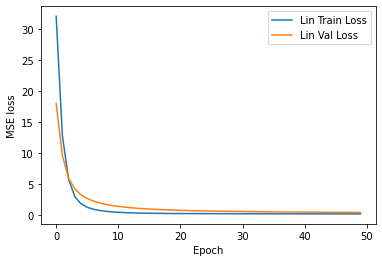

In [17]:
model_lin, tl_lin, vl_lin = run_linear_model(train_dl, test_dl)

# to plot loss
lin_data_label = list(zip([tl_lin,vl_lin], ['Lin Train Loss','Lin Val Loss']))
quick_loss_plot(lin_data_label)

In [18]:
seqs1 = ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]
seqs2 = ['TATAAA', 'TAATAT','CCTATA','AAGCGA','GCGAAA','TTGCGA','GCGTAA', 'TATTAA','TTTATT']

quick_seq_pred(model_lin, seqs1)
print()
quick_seq_pred(model_lin, seqs2)

AAAAAA 10.398273468017578
CCCCCC 5.962952136993408
GGGGGG 3.825958251953125
TTTTTT 0.965394139289856
AACCAA 8.25616455078125
CCGGGG 4.591191291809082
GGGTAA 5.241413116455078
TTTCGT 1.683756947517395
TGTAAT 5.03487491607666

TATAAA 7.314726829528809
TAATAT 5.580296516418457
CCTATA 5.829018592834473
AAGCGA 6.710100173950195
GCGAAA 7.293404579162598
TTGCGA 3.023855447769165
GCGTAA 5.565989971160889
TATTAA 5.587312698364258
TTTATT 2.6928086280822754


# Next with specific patterns that mean higher score

Example train seq


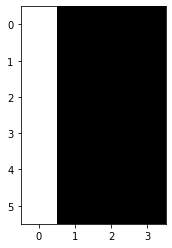

[8, 28, 43, 11, 21, 44, 37, 1, 0, 47, 26, 32, 38, 12, 17, 40, 42, 30, 33, 14, 10, 41, 16, 9, 18, 2, 7, 24, 22, 5, 25, 15, 19, 48, 46, 29, 20, 27, 34, 31, 13, 39, 3, 36, 4, 45, 35, 6, 23]
Train #: 39
Test #: 10
Y test: tensor([[14.8000],
        [ 9.0000],
        [ 0.4000],
        [ 4.1000],
        [ 9.9000],
        [ 0.3000],
        [13.9000],
        [ 0.2000],
        [ 5.0000],
        [ 1.1000]], dtype=torch.float64)


In [19]:
# fake data: 
# TAT = really high: >13.0 (10 examples)
# GCG = really low:  < 1.0 (10 examples)
data2 = [
    ('AAAAAA', 10.0),
    ('AATATA', 15.0),
    ('TATAAA', 14.9),
    ('TAATAT', 14.8),
    ('ATAAAA', 9.0),
    ('AAAACA', 9.8),
    ('GCGACA', 0.4),
    ('CCCCCC', 7.0),
    ('CGGACC', 6.8),
    ('CTATCC', 13.6),
    ('GGGACG', 6.2),
    ('CGGGCG', 0.5),
    ('GGGGGG', 4.0),
    ('GCCGGT', 4.1),
    ('TGTATT', 12.3),
    ('CGGTTG', 3.4),
    ('TTGCGT', 0.1),
    ('TTTTTT', 1.0),
    ('TAATTA', 5.1),
    ('GAGTGA', 5.3),
    ('AAATAT', 14.9),
    ('AAGCGA', 0.5),
    ('TTAGCT', 3.2),
    ('CAAAAA', 9.9),
    ('ACAAAA', 9.8),
    ('AAAACA', 9.8),
    ('CCTATA', 14.5),
    ('CCCGCC', 6.8),
    ('CGGATC', 6.6),
    ('CACGCG', 0.3),
    ('AGGACG', 6.5),
    ('CGTGCG', 0.3),
    ('GGGGGA', 4.3),
    ('GCCGGA', 4.5),
    ('TGGTGA', 3.5),
    ('CGGTAT', 13.9),
    ('TTGCGA', 0.2),
    ('TTTTTG', 1.1),
    ('TATTAA', 14.7),
    ('GAGTGC', 5.0),
    ('AAATAC', 8.7),
    ('AGCGAA', 0.6),
    ('TTCTTT', 1.3),
    ('TTTATT', 13.6),
    ('TTTTGT', 1.1),
    ('GTTTTT', 1.1),
    ('AACAAA', 9.8),
    ('AAGCGA', 0.6),
    ('GCGAAA', 0.7),
]

train_dl2, test_dl2 = build_dataloaders(data2)

### Linear model

In [20]:
model_lin2, tl_lin2, vl_lin2 = run_linear_model(train_dl2, test_dl2)

quick_seq_pred(model_lin2, seqs1)
print()
quick_seq_pred(model_lin2, seqs2)

0 37.75032558441162
1 28.060701370239258
2 24.737031936645508
3 23.6913782119751
4 23.206756401062012
5 22.89062786102295
6 22.740284538269044
7 22.6205997467041
8 22.598509216308592
9 22.47325744628906
10 22.515044021606446
11 22.596462631225585
12 22.673718070983888
13 22.65317306518555
14 22.767355155944824
15 22.8192045211792
16 22.875567626953124
17 22.972615814208986
18 23.08875617980957
19 23.130905532836913
20 23.192457580566405
21 23.306858825683594
22 23.427370834350587
23 23.479128646850587
24 23.459610176086425
25 23.573574447631835
26 23.661290168762207
27 23.68685245513916
28 23.7252836227417
29 23.795928382873534
30 23.858413696289062
31 23.932452774047853
32 24.004910469055176
33 24.100378036499023
34 24.119317245483398
35 24.166591262817384
36 24.177956771850585
37 24.274369049072266
38 24.291184616088866
39 24.3171745300293
40 24.37635955810547
41 24.446471405029296
42 24.437253189086913
43 24.48049430847168
44 24.582892227172852
45 24.6227596282959
46 24.622561645507

### CNN Model

In [36]:
model_cnn, tl_cnn, vl_cnn = run_cnn_model(train_dl2, test_dl2)

quick_seq_pred(model_cnn, seqs1)
print()
quick_seq_pred(model_cnn, seqs2)

0 35.366334438323975
1 20.265235137939452
2 62.059242248535156
3 24.049005031585693
4 31.906518745422364
5 18.534028434753417
6 15.446139907836914
7 13.333488655090331
8 12.438187670707702
9 16.80329296588898
10 10.68525708913803
11 10.147337591648101
12 8.398204171657563
13 8.239417505264282
14 7.26671884059906
15 12.21199427843094
16 7.254589939117432
17 7.54597287774086
18 5.967415618896484
19 5.216524010896682
20 10.227989459037781
21 8.38211522102356
22 5.361992621421814
23 11.492729568481446
24 6.505673480033875
25 5.7576475739479065
26 4.723767805099487
27 5.29118664264679
28 3.6599607169628143
29 3.337708902359009
30 4.819340635836125
31 3.1589978456497194
32 3.550232541561127
33 5.070481538772583
34 2.7439633905887604
35 2.898927688598633
36 2.721182328462601
37 2.4567948818206786
38 2.462918001413345
39 2.6627688974142076
40 2.5665956854820253
41 2.673353362083435
42 2.403833156824112
43 2.43484867811203
44 2.5391104340553285
45 2.4613362431526182
46 2.657132166624069
47 2.70

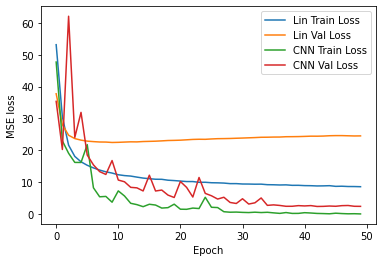

In [37]:
#  plot loss
lin_data_label = list(zip([tl_lin2,vl_lin2,tl_cnn, vl_cnn], 
                          ['Lin Train Loss','Lin Val Loss', 'CNN Train Loss','CNN Val Loss']))
quick_loss_plot(lin_data_label)

## inspect CNN model

In [38]:
model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [39]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv1d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv1d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

In [40]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_cnn)
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

Total convolutional layers: 1
WEIGHT: Parameter containing:
tensor([[[ 4.4875e-02, -2.7829e-01, -2.0436e-01],
         [-1.9843e-01, -2.0336e-01, -1.6284e-01],
         [-1.1111e-01,  1.1130e-01, -8.3231e-02],
         [-1.6290e-01,  5.8529e-02, -9.4657e-02]],

        [[ 1.0746e-01,  1.4719e-01, -2.4126e-01],
         [ 2.8097e-01,  7.0048e-02,  4.4444e-02],
         [ 2.5833e-01, -8.5556e-02,  1.4471e-02],
         [ 2.0122e-01, -1.7655e-01, -1.1243e-01]],

        [[-2.8028e-01,  2.2965e-01, -1.9659e-01],
         [ 3.2798e-02,  1.1725e-01, -3.4877e-02],
         [ 1.5082e-01, -1.7673e-01, -4.1111e-02],
         [ 1.8277e-01, -2.8314e-01,  2.1109e-01]],

        [[ 3.0206e-02, -1.2635e-04,  2.0362e-01],
         [ 1.3773e-01, -3.9012e-03, -2.2546e-01],
         [ 3.6521e-01,  6.8344e-02,  1.0832e-01],
         [-1.0953e-01, -1.1297e-01, -1.5518e-01]],

        [[-1.1936e-01,  2.3930e-01, -1.4138e-01],
         [-1.4418e-01,  2.1507e-01,  6.3057e-02],
         [ 1.1628e-01, -2.4663e-

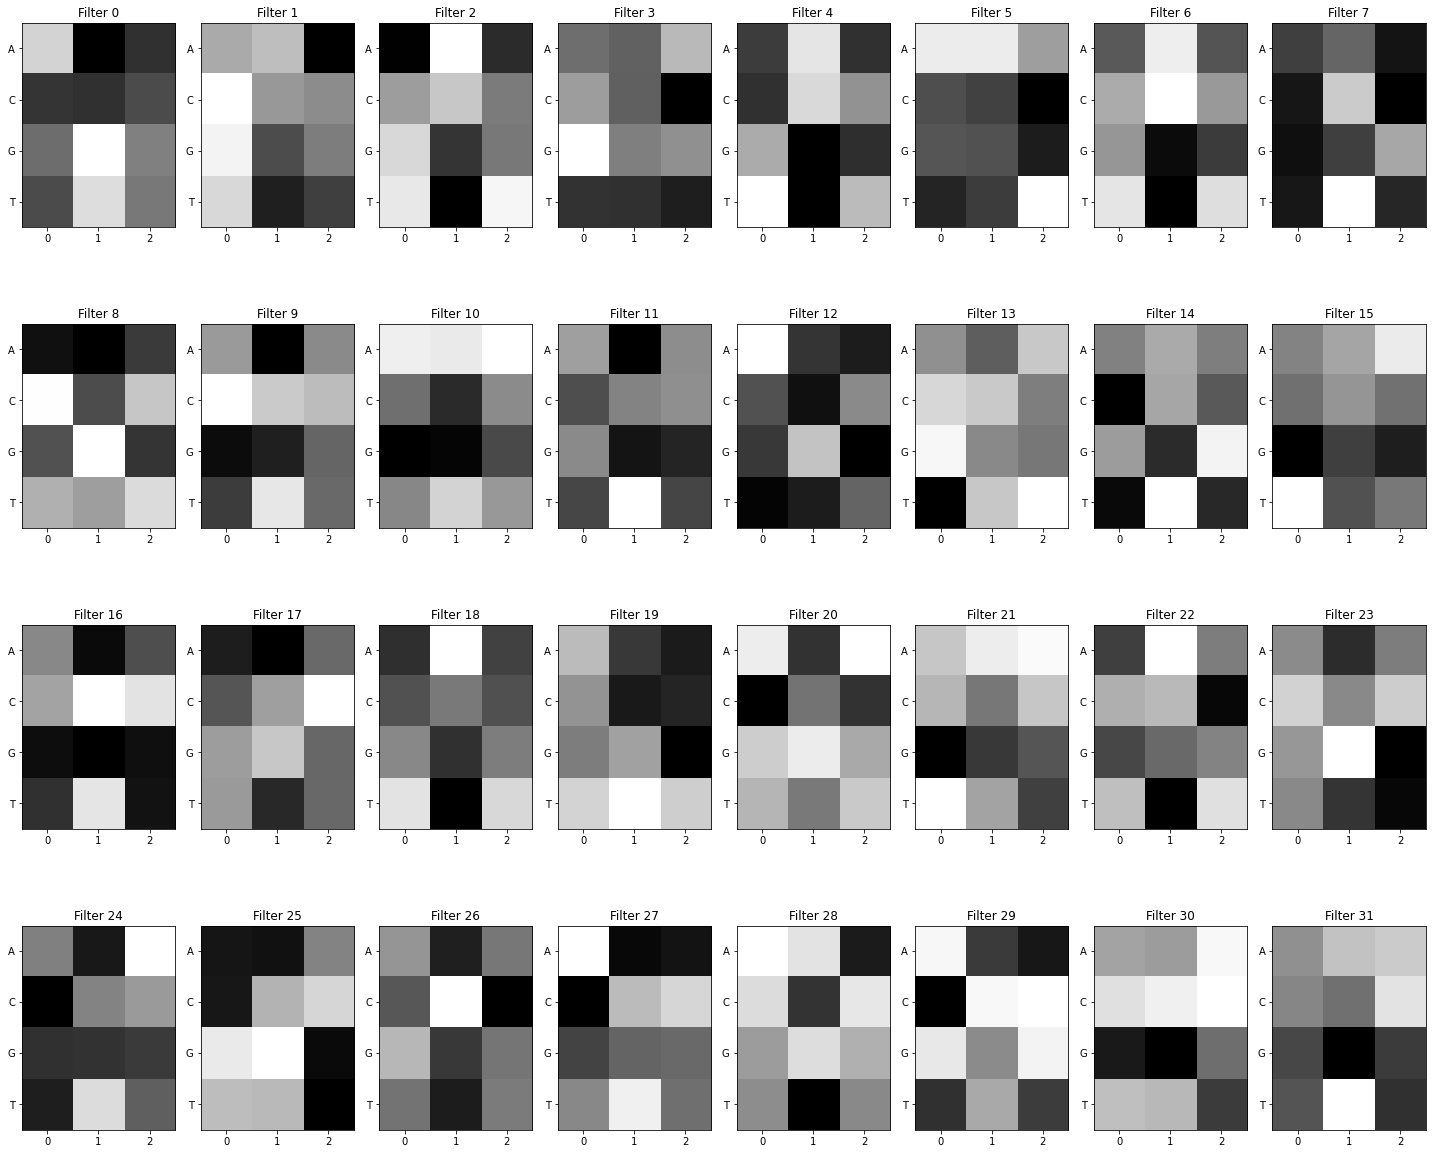

In [41]:
def view_filters(model_weights, num_cols=8):
    num_filt = model_weights[0].shape[0]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights[0]):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(3))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
view_filters(model_weights)

# Figure out how to get highest scoring subseqs

In [42]:
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(one_hot_encode(seq)).view(-1,6,4).permute(0,2,1)
    
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[0]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            activated_positions = [x.item() for x in torch.where(act_vec>0)[0]]
            
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                subseq_tensor = torch.tensor(one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor
            
            
            
    return filter_pwms

In [43]:
train_seqs = [x[0] for x in data2]
print(train_seqs)

['AAAAAA', 'AATATA', 'TATAAA', 'TAATAT', 'ATAAAA', 'AAAACA', 'GCGACA', 'CCCCCC', 'CGGACC', 'CTATCC', 'GGGACG', 'CGGGCG', 'GGGGGG', 'GCCGGT', 'TGTATT', 'CGGTTG', 'TTGCGT', 'TTTTTT', 'TAATTA', 'GAGTGA', 'AAATAT', 'AAGCGA', 'TTAGCT', 'CAAAAA', 'ACAAAA', 'AAAACA', 'CCTATA', 'CCCGCC', 'CGGATC', 'CACGCG', 'AGGACG', 'CGTGCG', 'GGGGGA', 'GCCGGA', 'TGGTGA', 'CGGTAT', 'TTGCGA', 'TTTTTG', 'TATTAA', 'GAGTGC', 'AAATAC', 'AGCGAA', 'TTCTTT', 'TTTATT', 'TTTTGT', 'GTTTTT', 'AACAAA', 'AAGCGA', 'GCGAAA']


In [44]:
filter_activations = get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AATATA
Running seq TATAAA
Running seq TAATAT
Running seq ATAAAA
Running seq AAAACA
Running seq GCGACA
Running seq CCCCCC
Running seq CGGACC
Running seq CTATCC
Running seq GGGACG
Running seq CGGGCG
Running seq GGGGGG
Running seq GCCGGT
Running seq TGTATT
Running seq CGGTTG
Running seq TTGCGT
Running seq TTTTTT
Running seq TAATTA
Running seq GAGTGA
Running seq AAATAT
Running seq AAGCGA
Running seq TTAGCT
Running seq CAAAAA
Running seq ACAAAA
Running seq AAAACA
Running seq CCTATA
Running seq CCCGCC
Running seq CGGATC
Running seq CACGCG
Running seq AGGACG
Running seq CGTGCG
Running seq GGGGGA
Running seq GCCGGA
Running seq TGGTGA
Running seq CGGTAT
Running seq TTGCGA
Running seq TTTTTG
Running seq TATTAA
Running seq GAGTGC
Running seq AAATAC
Running seq AGCGAA
Running seq TTCTTT
Running seq TTTATT
Running seq TTTTGT
Running seq GTTTTT
Running seq AACAAA
Running seq AAGCGA
Running seq GCGAAA


In [45]:
len(filter_activations)

32

In [46]:
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    
    assert(model_weights[0].shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights[0]):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(3))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()



/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


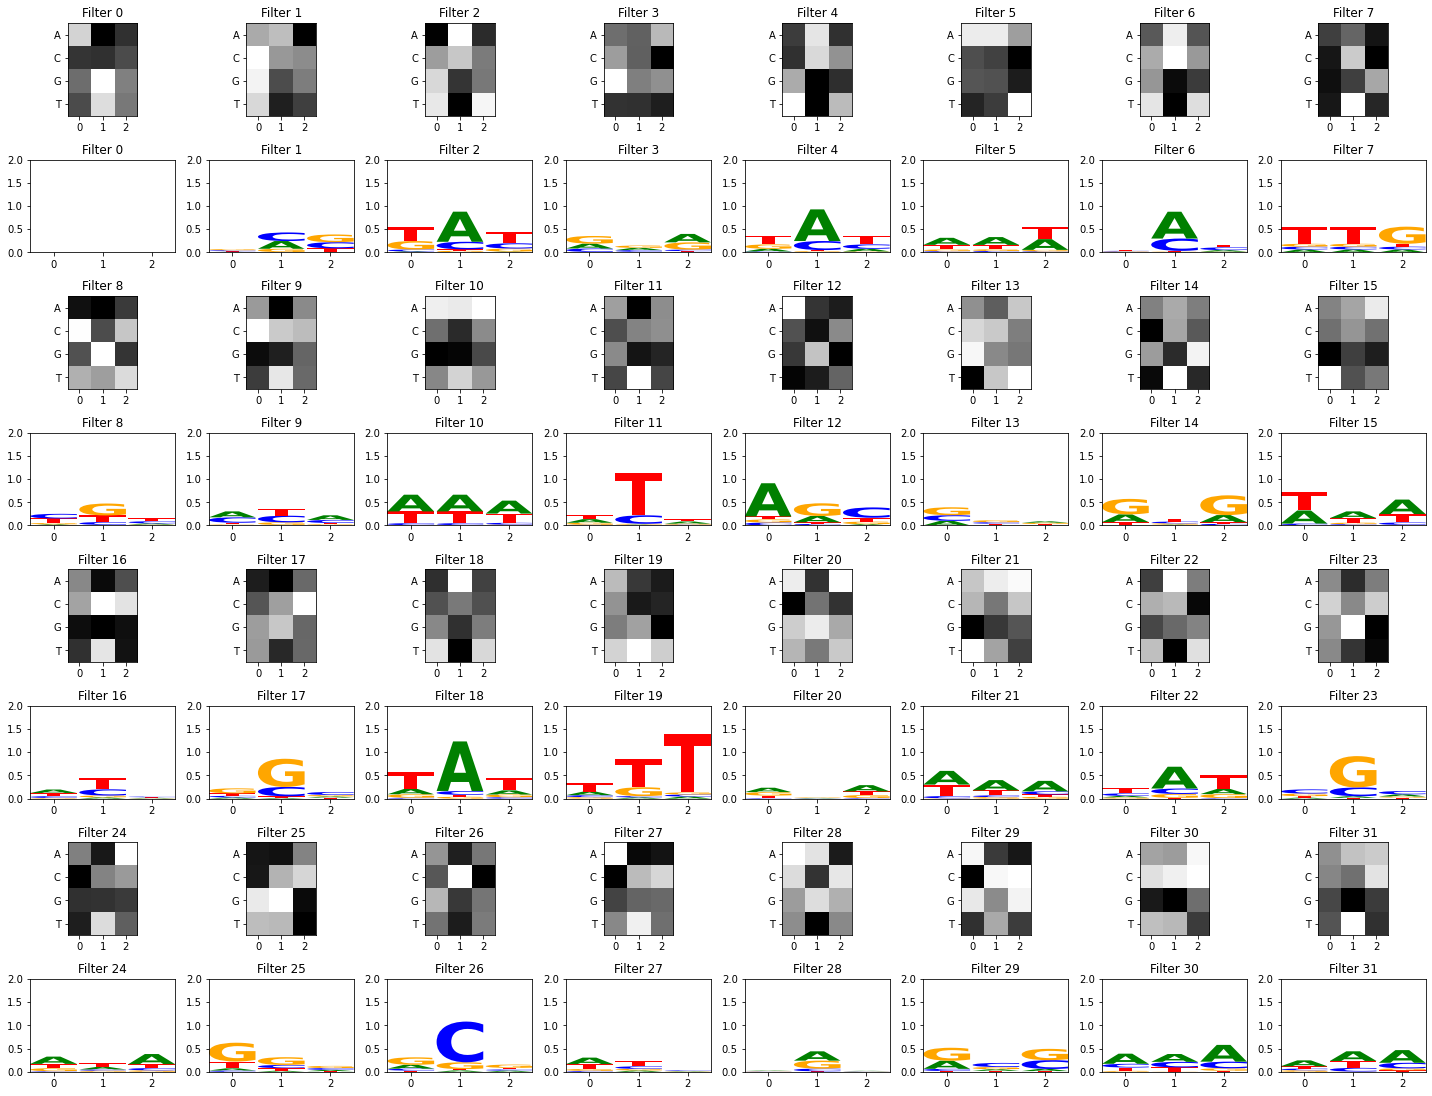

In [47]:
view_filters_and_logos(model_weights,filter_activations)

### view information content

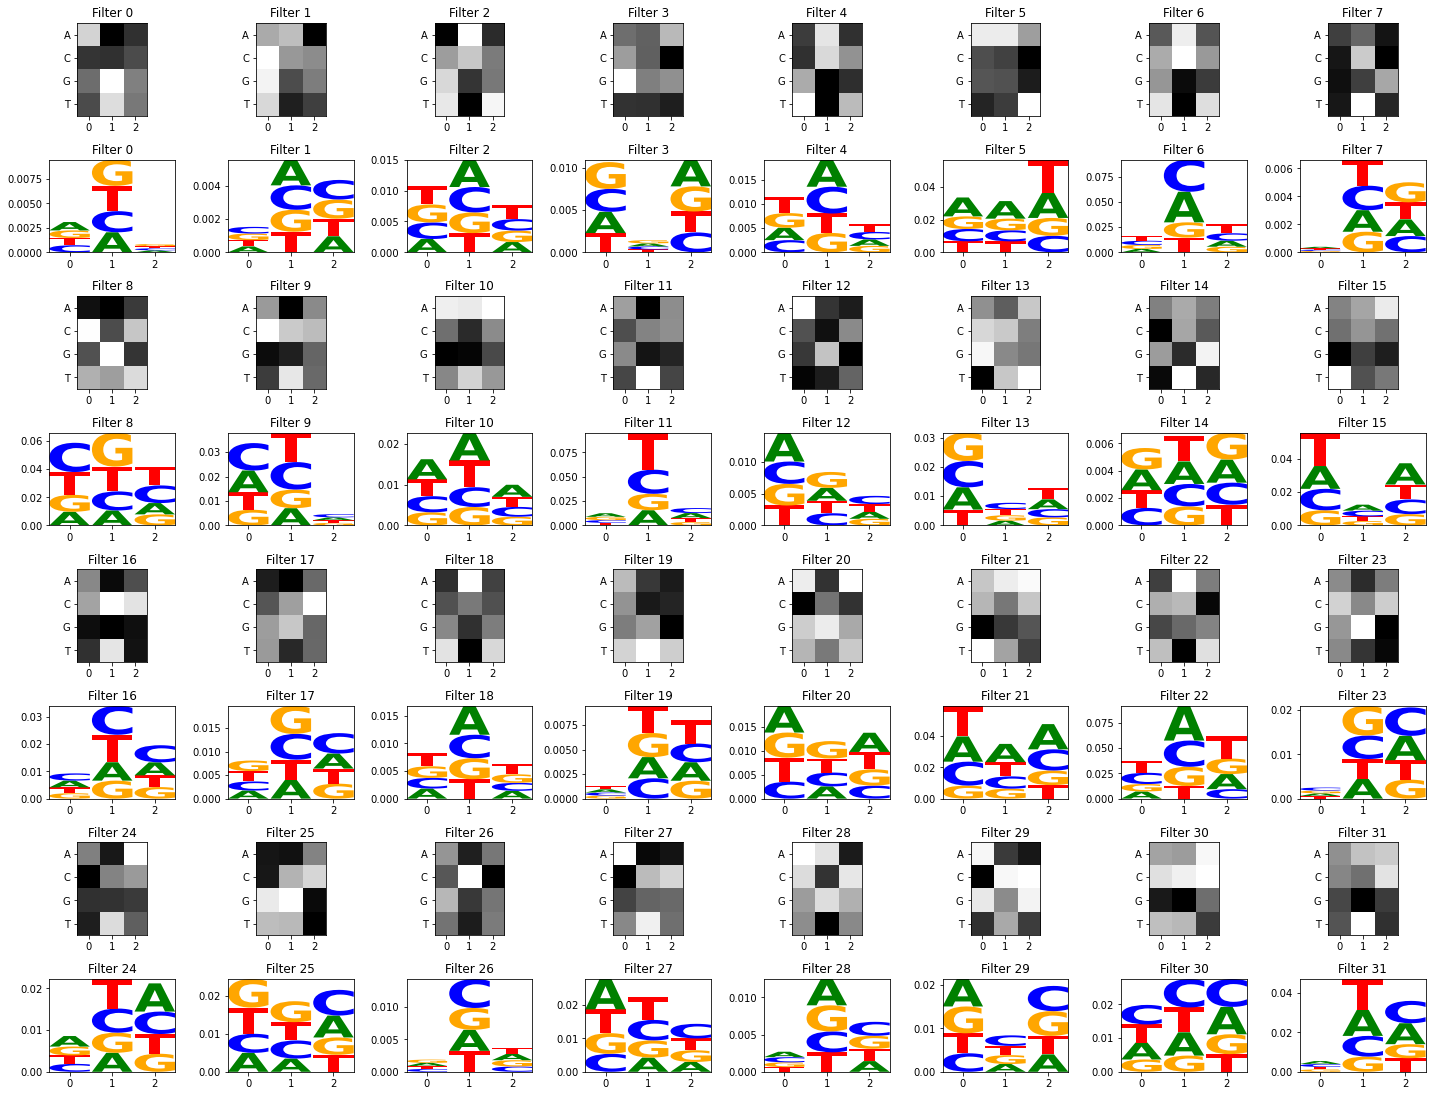

In [48]:
plt.figure(figsize=(20, 17))

j=0
for i, filter in enumerate(model_weights[0]):
    if (i)%8 == 0:
        j += 8
#     print('i:', i)
#     print('j:', j)
#     print('i%8 == 0', i%8 == 0)
# #     print('i+1%9 =?', (i+1)%9)
#     print("i+j+1=", i+j+1)
#     print("i+j+1+4=", i+j+1+8)
#     print("*******")
    
    #fig,ax = plt.subplots() # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    ax1 = plt.subplot(9, 8, i+j+1)
    ax1.imshow(filter.detach(), cmap='gray')
    ax1.set_yticks(np.arange(4))
    ax1.set_yticklabels(['A', 'C', 'G','T'])
    ax1.set_xticks(np.arange(3))
    ax1.set_title(f"Filter {i}")
    
    
    ax2 = plt.subplot(9, 8, i+j+1+8)
    filt_df = pd.DataFrame(filter.T.detach().numpy(),columns=['A','C','G','T'])
    logo1 = logomaker.transform_matrix(filt_df,from_type='weight',to_type='information')
    crp_logo1 = logomaker.Logo(logo1,ax=ax2)
    #ax2.set_ylim(0,2)
    ax2.set_title(f"Filter {i}")
    
plt.tight_layout()


### view information content, 0-2.0

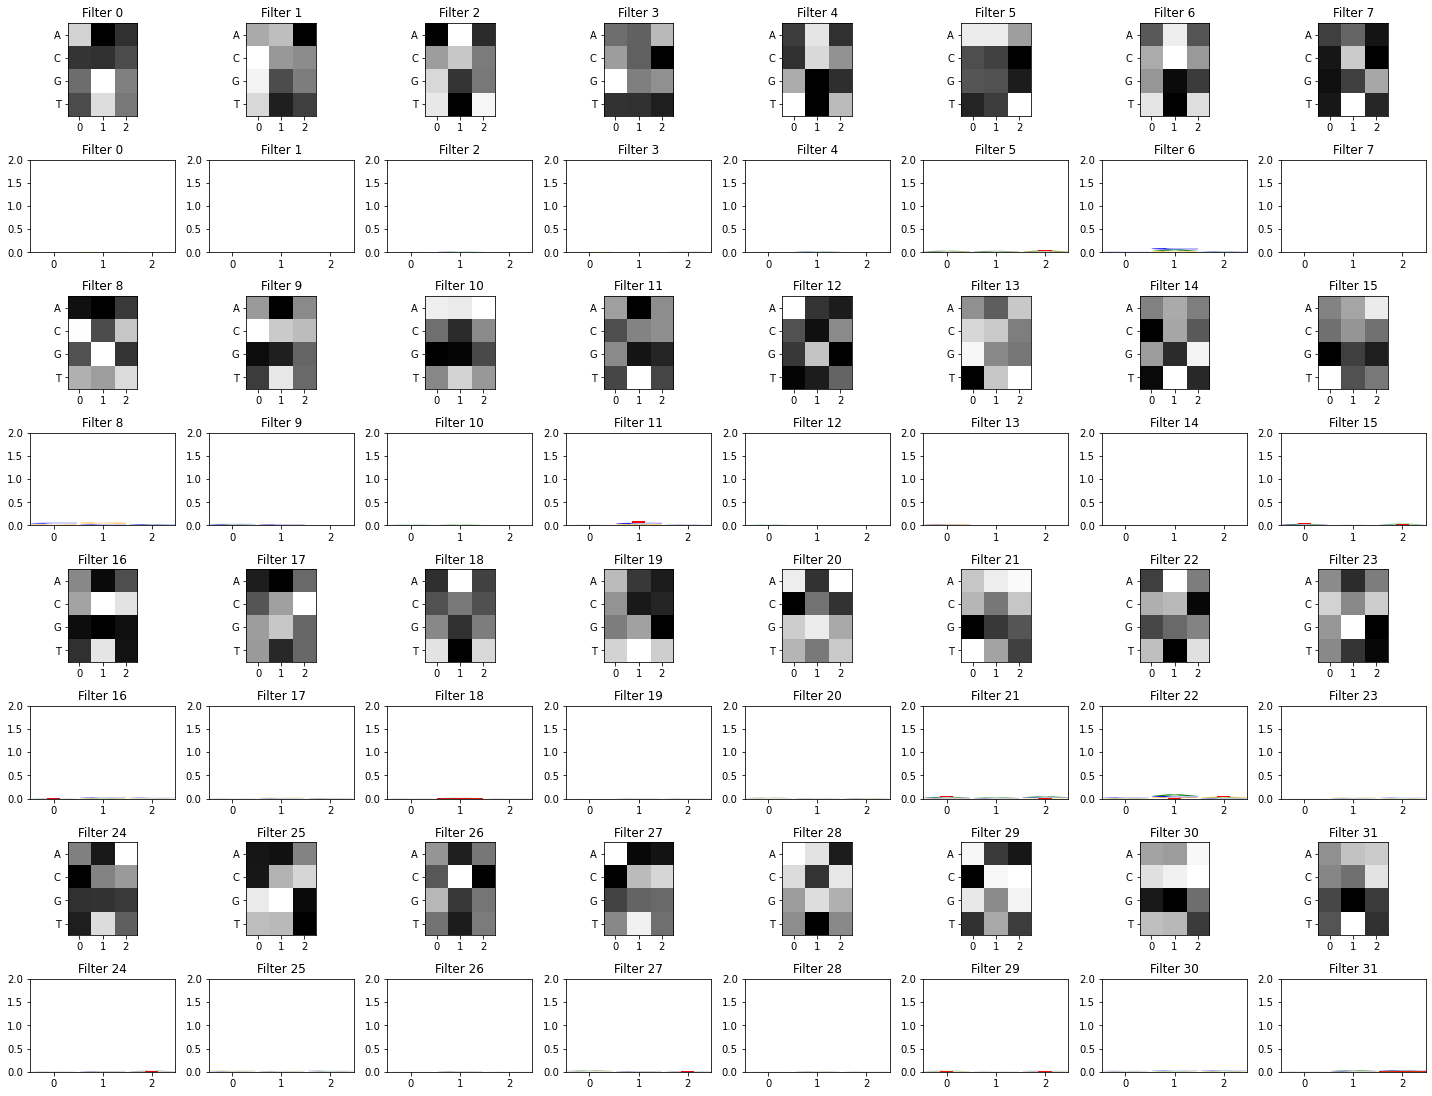

In [49]:
plt.figure(figsize=(20, 17))

j=0
for i, filter in enumerate(model_weights[0]):
    if (i)%8 == 0:
        j += 8
#     print('i:', i)
#     print('j:', j)
#     print('i%8 == 0', i%8 == 0)
# #     print('i+1%9 =?', (i+1)%9)
#     print("i+j+1=", i+j+1)
#     print("i+j+1+4=", i+j+1+8)
#     print("*******")
    
    #fig,ax = plt.subplots() # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    ax1 = plt.subplot(9, 8, i+j+1)
    ax1.imshow(filter.detach(), cmap='gray')
    ax1.set_yticks(np.arange(4))
    ax1.set_yticklabels(['A', 'C', 'G','T'])
    ax1.set_xticks(np.arange(3))
    ax1.set_title(f"Filter {i}")
    
    
    ax2 = plt.subplot(9, 8, i+j+1+8)
    filt_df = pd.DataFrame(filter.T.detach().numpy(),columns=['A','C','G','T'])
    logo1 = logomaker.transform_matrix(filt_df,from_type='weight',to_type='information')
    crp_logo1 = logomaker.Logo(logo1,ax=ax2)
    ax2.set_ylim(0,2)
    ax2.set_title(f"Filter {i}")
    
plt.tight_layout()


### view probability

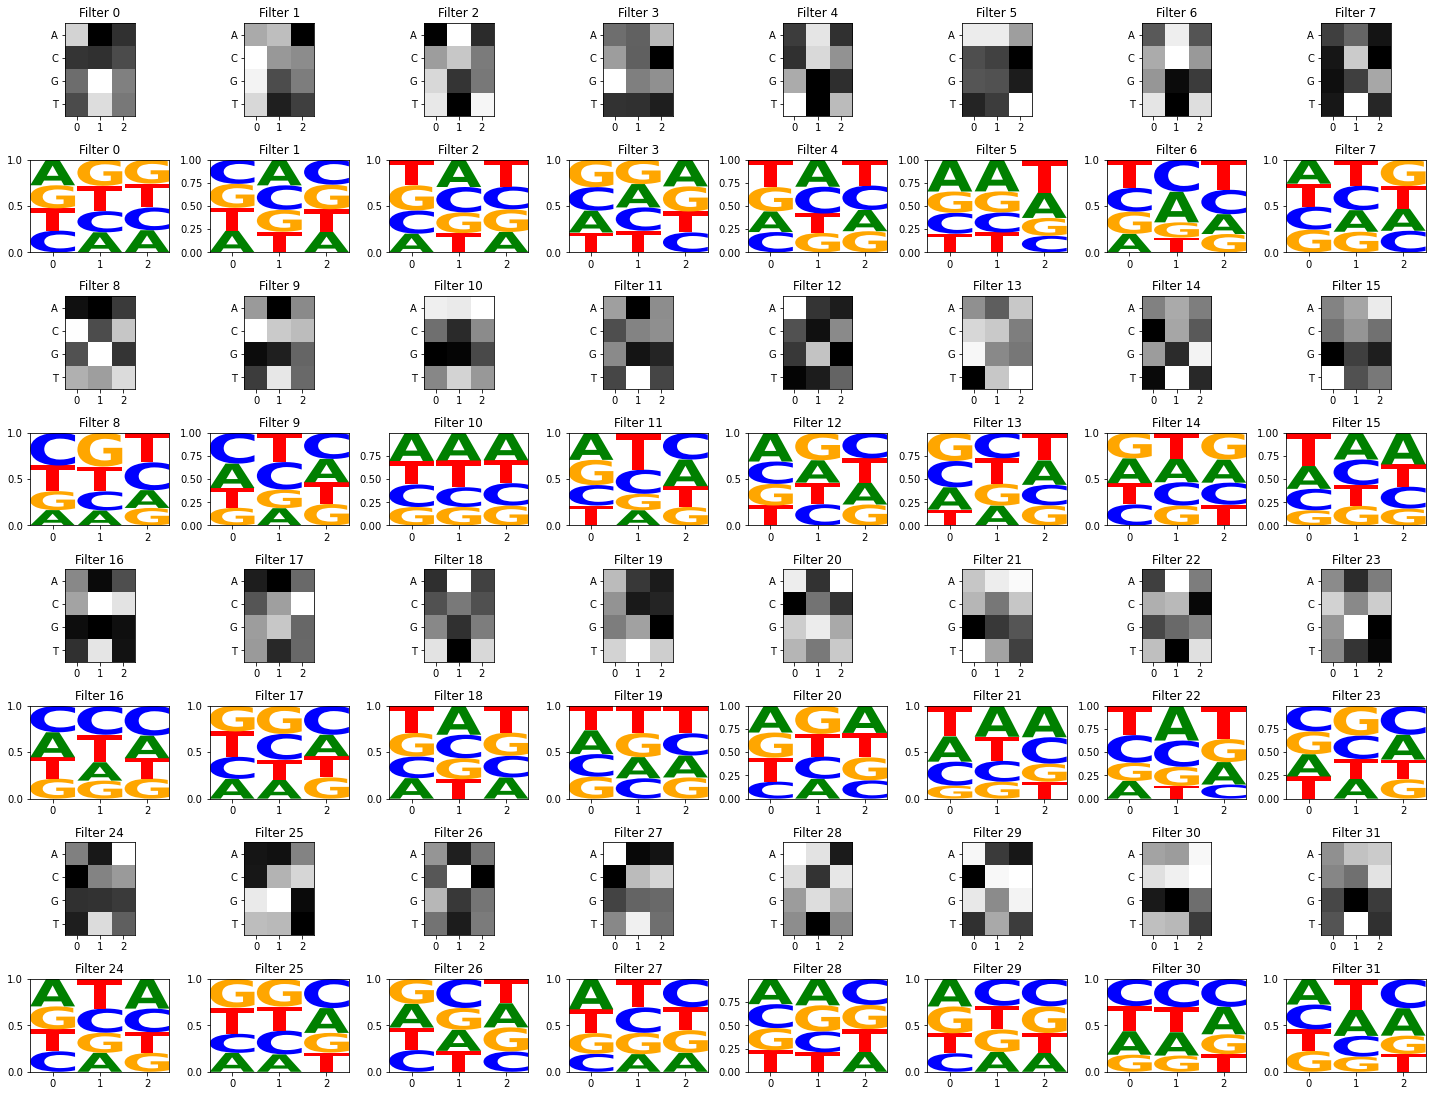

In [50]:
plt.figure(figsize=(20, 17))

j=0
for i, filter in enumerate(model_weights[0]):
    if (i)%8 == 0:
        j += 8
#     print('i:', i)
#     print('j:', j)
#     print('i%8 == 0', i%8 == 0)
# #     print('i+1%9 =?', (i+1)%9)
#     print("i+j+1=", i+j+1)
#     print("i+j+1+4=", i+j+1+8)
#     print("*******")
    
    #fig,ax = plt.subplots() # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    ax1 = plt.subplot(9, 8, i+j+1)
    ax1.imshow(filter.detach(), cmap='gray')
    ax1.set_yticks(np.arange(4))
    ax1.set_yticklabels(['A', 'C', 'G','T'])
    ax1.set_xticks(np.arange(3))
    ax1.set_title(f"Filter {i}")
    
    
    ax2 = plt.subplot(9, 8, i+j+1+8)
    filt_df = pd.DataFrame(filter.T.detach().numpy(),columns=['A','C','G','T'])
    logo1 = logomaker.transform_matrix(filt_df,from_type='weight',to_type='probability')
    crp_logo1 = logomaker.Logo(logo1,ax=ax2)
    #ax2.set_ylim(0,2)
    ax2.set_title(f"Filter {i}")
    
plt.tight_layout()


### view raw weights

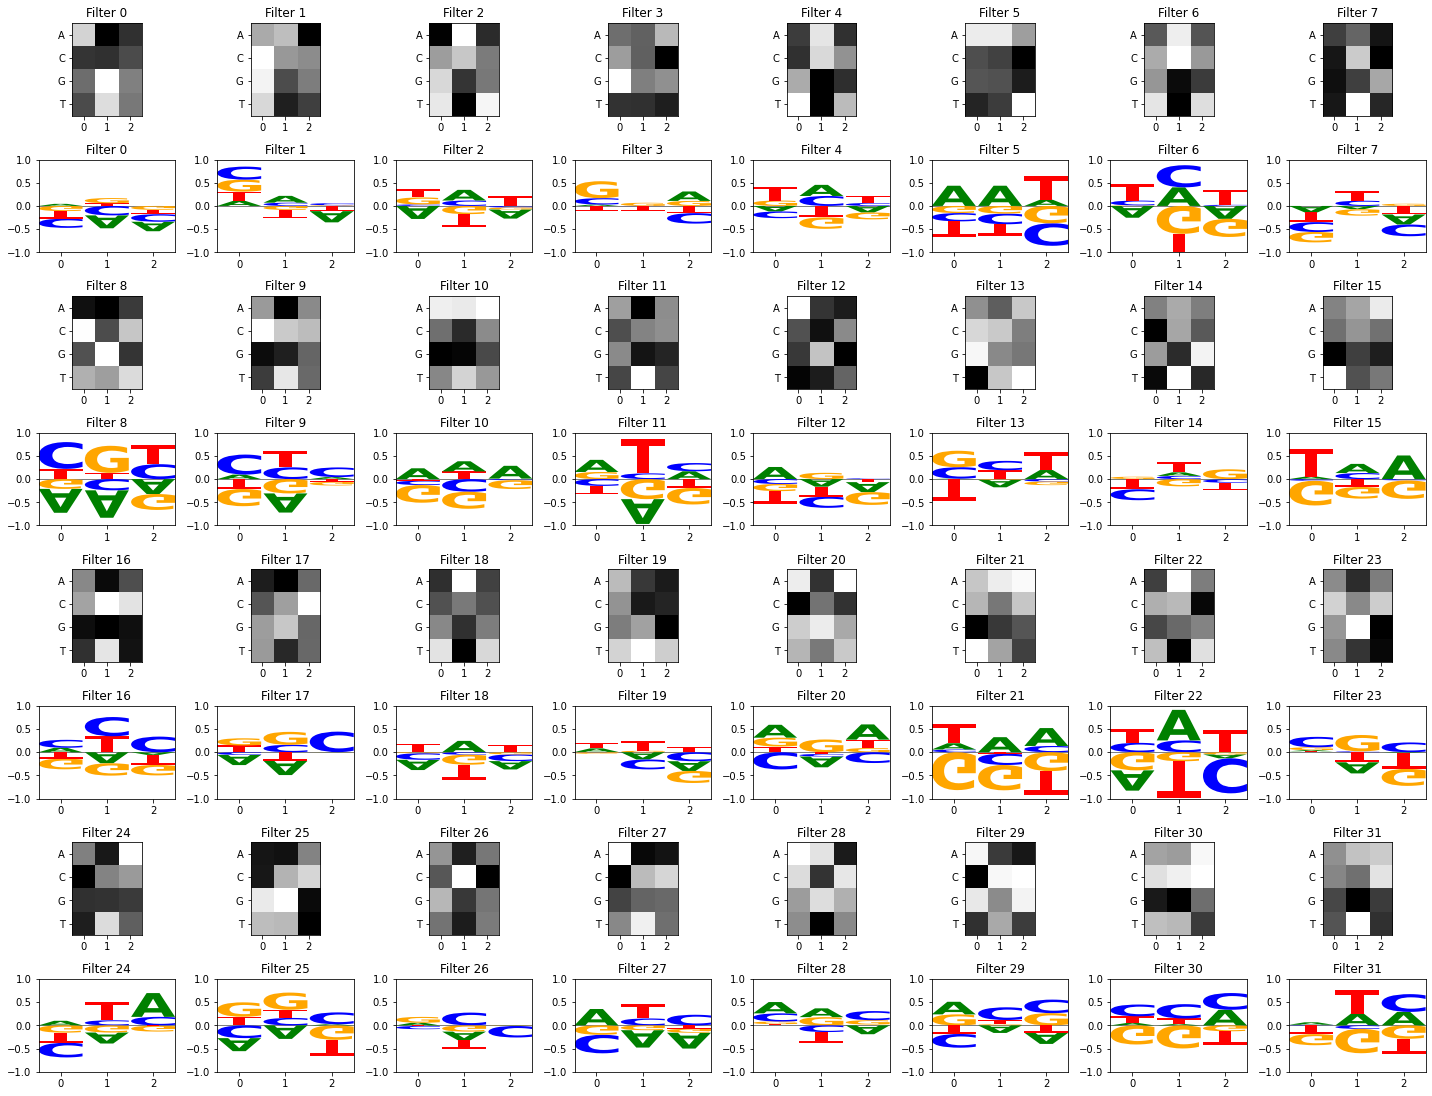

In [51]:
plt.figure(figsize=(20, 17))

j=0
for i, filter in enumerate(model_weights[0]):
    if (i)%8 == 0:
        j += 8
#     print('i:', i)
#     print('j:', j)
#     print('i%8 == 0', i%8 == 0)
# #     print('i+1%9 =?', (i+1)%9)
#     print("i+j+1=", i+j+1)
#     print("i+j+1+4=", i+j+1+8)
#     print("*******")
    
    #fig,ax = plt.subplots() # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    ax1 = plt.subplot(9, 8, i+j+1)
    ax1.imshow(filter.detach(), cmap='gray')
    ax1.set_yticks(np.arange(4))
    ax1.set_yticklabels(['A', 'C', 'G','T'])
    ax1.set_xticks(np.arange(3))
    ax1.set_title(f"Filter {i}")
    
    
    ax2 = plt.subplot(9, 8, i+j+1+8)
    filt_df = pd.DataFrame(filter.T.detach().numpy(),columns=['A','C','G','T'])
    #logo1 = logomaker.transform_matrix(filt_df,from_type='weight',to_type='information')
    crp_logo1 = logomaker.Logo(filt_df,ax=ax2)
    ax2.set_ylim(-1,1)
    ax2.set_title(f"Filter {i}")
    
plt.tight_layout()


# tinkering

In [24]:
ch = list(model_cnn.conv_net.children())

In [25]:
ch[0].weight.shape

torch.Size([32, 4, 3])

In [26]:
list(ch[0].children())

[]

In [27]:
model_children = list(model_cnn.children())

In [28]:
model_children

[Sequential(
   (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
   (1): ReLU(inplace=True)
   (2): Flatten(start_dim=1, end_dim=-1)
   (3): Linear(in_features=128, out_features=10, bias=True)
   (4): ReLU(inplace=True)
   (5): Linear(in_features=10, out_features=1, bias=True)
 )]

In [142]:
model_children[0][0].bias

Parameter containing:
tensor([-0.1135, -0.0889, -0.1759, -0.0541,  0.1679, -0.2155, -0.3083, -0.1015,
        -0.1272,  0.1190, -0.2913, -0.1648, -0.2610, -0.0027, -0.0925, -0.3114,
        -0.1065, -0.0536, -0.1021, -0.0265, -0.3810, -0.4497, -0.2795,  0.1515,
         0.0350,  0.0593, -0.0717, -0.1722, -0.1049, -0.4608,  0.1879, -0.1020],
       requires_grad=True)

In [223]:
one_hot_encode("ATA")

array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

In [230]:
q = torch.tensor(one_hot_encode("ATA")).view(-1,3,4).permute(0,2,1)
r = torch.tensor(one_hot_encode("GTA")).view(-1,3,4).permute(0,2,1)

In [242]:
torch.tensor(one_hot_encode("ATA")).view(-1,3,4).permute(0,2,1).squeeze(0)

tensor([[1., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.]], dtype=torch.float64)

In [231]:
t[3] + q + r

tensor([[[1., 0., 2.],
         [0., 0., 0.],
         [1., 0., 0.],
         [0., 2., 0.]]], dtype=torch.float64)

In [181]:
test_res = get_conv_output_for_seq("TATAAT", conv_layers[0])

Running seq TATAAT


In [206]:

for i,fil in enumerate(test_res[0]):
    print(i,fil)
    act = torch.where(fil>0)

0 tensor([-0.8475,  0.8678, -0.7138, -0.1538])
1 tensor([-0.7644, -0.1777, -0.7129, -0.6313])
2 tensor([-0.0078, -0.2545, -0.3318, -0.2625])
3 tensor([-0.0087, -0.7046, -0.4422, -0.1291])
4 tensor([-0.1842,  0.1390, -0.4872,  0.2682])
5 tensor([ 0.3756, -0.9901, -0.1412,  0.2439])
6 tensor([ 0.3864, -0.8757,  0.0927,  0.1317])
7 tensor([ 0.6009, -0.2642,  0.3986,  0.5958])
8 tensor([ 0.7391, -1.0308,  0.5151,  0.0341])
9 tensor([ 0.3157, -0.0375, -0.3019,  0.4507])
10 tensor([-0.5168,  1.4940,  0.5237, -0.0190])
11 tensor([-0.1356,  0.0624, -0.2439, -0.1069])
12 tensor([ 0.0106, -0.5521,  0.2380, -0.3713])
13 tensor([-0.6950,  1.2646,  0.0122, -0.1948])
14 tensor([-0.0168, -0.5901, -0.5220, -0.6445])
15 tensor([-0.5340,  0.3218, -0.2878, -0.4827])
16 tensor([-0.2992, -0.0086, -0.9446,  0.3429])
17 tensor([0.5589, 0.6360, 0.8460, 0.8060])
18 tensor([-0.6416,  0.4535, -0.7670,  0.0068])
19 tensor([ 0.0385, -0.1458,  0.0574,  0.0060])
20 tensor([ 0.2865, -0.9599, -0.0633, -0.0462])
21 ten

In [216]:
act[0][1].item()

2

In [114]:
model_weights[0].shape

torch.Size([32, 4, 3])

In [115]:
conv_layers

[Conv1d(4, 32, kernel_size=(3,), stride=(1,))]

In [120]:
test_seq = torch.tensor(one_hot_encode(seqs1[6])).view(-1,6,4).permute(0,2,1)

#xb = xb.view(-1,6,4).permute(0,2,1) # reshape to 4bs x 4channel x 6len

In [124]:
seqs1[6]

'GGGTAA'

In [128]:
test_seq[:,:,:3]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [1., 1., 1.],
         [0., 0., 0.]]], dtype=torch.float64)

In [156]:
f = model_weights[0][1]
f

tensor([[-0.0798, -0.2572, -0.1539],
        [ 0.1709, -0.1131,  0.2211],
        [ 0.1692, -0.0018,  0.0310],
        [-0.2129,  0.1450, -0.2054]], grad_fn=<SelectBackward>)

In [157]:
test_seq[:,:,1:4]*f

tensor([[[-0.0000, -0.0000, -0.0000],
         [ 0.0000, -0.0000,  0.0000],
         [ 0.1692, -0.0018,  0.0000],
         [-0.0000,  0.0000, -0.2054]]], dtype=torch.float64,
       grad_fn=<MulBackward0>)

In [159]:
sum([ 0.1692, -0.0018, -0.2054,-0.0889])

-0.1269

### sum of all filter weights plus learned filter bias!

In [122]:
res = conv_layers[0](test_seq.float())

In [108]:
res.shape

torch.Size([1, 32, 4])

In [155]:
model_children[0][0].bias

Parameter containing:
tensor([-0.1135, -0.0889, -0.1759, -0.0541,  0.1679, -0.2155, -0.3083, -0.1015,
        -0.1272,  0.1190, -0.2913, -0.1648, -0.2610, -0.0027, -0.0925, -0.3114,
        -0.1065, -0.0536, -0.1021, -0.0265, -0.3810, -0.4497, -0.2795,  0.1515,
         0.0350,  0.0593, -0.0717, -0.1722, -0.1049, -0.4608,  0.1879, -0.1020],
       requires_grad=True)

In [123]:
res

tensor([[[-0.0667,  0.3556,  0.6244, -0.7138],
         [ 0.1095, -0.1270,  0.0713, -0.7129],
         [-0.0290, -0.4138, -0.3334, -0.3318],
         [ 0.4152,  0.4242, -0.3529, -0.4422],
         [-0.1102, -0.0078, -0.2970, -0.4872],
         [ 0.5852,  0.6384, -0.7163, -0.1412],
         [ 0.2305,  0.1069, -0.7420,  0.0927],
         [-0.7613, -0.5461, -0.7204,  0.3986],
         [-0.2880, -0.1613, -0.8909,  0.5151],
         [-1.0263, -0.2601, -0.4158, -0.3019],
         [-1.7366, -1.7781,  0.3163,  0.5237],
         [-0.0844,  0.0602, -0.2106, -0.2439],
         [-0.2261, -0.0128, -0.0225,  0.2380],
         [-0.5172, -0.4643,  0.9156,  0.0122],
         [ 0.4368,  0.4254, -0.1405, -0.5220],
         [-0.4949, -0.3804, -0.0036, -0.2878],
         [-0.3222,  0.1311, -0.3275, -0.9446],
         [-0.9385, -0.5704, -0.3223,  0.8460],
         [ 0.4214,  0.7294,  0.4730, -0.7670],
         [-0.0617, -0.0336, -0.2699,  0.0574],
         [ 0.2054,  0.1205, -0.5585, -0.0633],
         [-0.

In [163]:
model_children[0][1](res)

tensor([[[0.0000, 0.3556, 0.6244, 0.0000],
         [0.1095, 0.0000, 0.0713, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.4152, 0.4242, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.5852, 0.6384, 0.0000, 0.0000],
         [0.2305, 0.1069, 0.0000, 0.0927],
         [0.0000, 0.0000, 0.0000, 0.3986],
         [0.0000, 0.0000, 0.0000, 0.5151],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3163, 0.5237],
         [0.0000, 0.0602, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.2380],
         [0.0000, 0.0000, 0.9156, 0.0122],
         [0.4368, 0.4254, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1311, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.8460],
         [0.4214, 0.7294, 0.4730, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0574],
         [0.2054, 0.1205, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.4794],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0

In [160]:
model_weights[0][5] # GGT

tensor([[-0.1054,  0.1976, -0.1496],
        [-0.0518, -0.2451, -0.2842],
        [ 0.1685,  0.3183,  0.3140],
        [ 0.0263, -0.5196,  0.3672]], grad_fn=<SelectBackward>)

In [161]:
test_seq

tensor([[[0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.]]], dtype=torch.float64)

In [109]:
res

tensor([[[-0.0201, -0.0201, -0.0201, -0.0201],
         [-0.5798, -0.5798, -0.5798, -0.5798],
         [-0.5865, -0.5865, -0.5865, -0.5865],
         [-0.5626, -0.5626, -0.5626, -0.5626],
         [-0.0349, -0.0349, -0.0349, -0.0349],
         [-0.2729, -0.2729, -0.2729, -0.2729],
         [-0.1620, -0.1620, -0.1620, -0.1620],
         [ 0.3935,  0.3935,  0.3935,  0.3935],
         [-0.1899, -0.1899, -0.1899, -0.1899],
         [-0.1669, -0.1669, -0.1669, -0.1669],
         [ 1.0215,  1.0215,  1.0215,  1.0215],
         [-0.2152, -0.2152, -0.2152, -0.2152],
         [-0.1440, -0.1440, -0.1440, -0.1440],
         [ 0.5123,  0.5123,  0.5123,  0.5123],
         [-1.1497, -1.1497, -1.1497, -1.1497],
         [-0.2365, -0.2365, -0.2365, -0.2365],
         [-0.3025, -0.3025, -0.3025, -0.3025],
         [ 1.0931,  1.0931,  1.0931,  1.0931],
         [-0.1186, -0.1186, -0.1186, -0.1186],
         [ 0.0248,  0.0248,  0.0248,  0.0248],
         [-0.3960, -0.3960, -0.3960, -0.3960],
         [-0.

In [85]:
[one_hot_encode(seq) for seq in seqs1]

[array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1.]),
 array([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0.]),
 array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        0., 

In [35]:
# train test split
idxs = list(range(df.shape[0]))
random.shuffle(idxs)
print(idxs)

split = int(len(idxs)*0.8)
train_idxs = idxs[:split]
test_idxs = idxs[split:]

print("Train #:", len(train_idxs))
print("Test #:", len(test_idxs))

[17, 1, 21, 11, 44, 42, 48, 12, 15, 20, 39, 19, 43, 36, 37, 7, 40, 18, 30, 25, 33, 45, 38, 32, 23, 10, 14, 16, 24, 13, 27, 41, 8, 31, 29, 46, 9, 5, 22, 3, 4, 34, 47, 0, 2, 26, 6, 28, 35]
Train #: 39
Test #: 10


In [ ]:
def view_motif(m1,m2):
    '''
    Given two Motif objects from the BioPython motifs module,
    create a sequence logo from their PWMs
    '''
    df1 = pd.DataFrame(m1.pwm, columns=['A','C','G','T'])
    df2 = pd.DataFrame(m2.pwm, columns=['A','C','G','T'])

    # initialize 2 panel figure
    fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=[10,2])

    # block 1
    logo1 = logomaker.transform_matrix(df1,from_type='probability',to_type='information')
    crp_logo1 = logomaker.Logo(logo1,ax=ax1)

    # block 2
    logo2 = logomaker.transform_matrix(df2,from_type='probability',to_type='information')
    crp_logo2 = logomaker.Logo(logo2,ax=ax2,)

    # labels
    df1_title = f"Motif Block 1"
    df2_title = f"Motif Block 2"
    ax1.set_title(df1_title)
    ax2.set_title(df2_title)
    ax1.set_xticks([])
    ax2.set_xticks([])

    plt.ylim(0,2)

    plt.show()

In [36]:
train_df = df[df.index.isin(train_idxs)]
test_df = df[df.index.isin(test_idxs)]

x_train = torch.tensor(list(train_df['oh'].values))
y_train = torch.tensor(list(train_df['score'].values)).unsqueeze(1)
x_test  = torch.tensor(list(test_df['oh'].values))
y_test  = torch.tensor(list(test_df['score'].values)).unsqueeze(1)

print(x_test)
print(y_test)

tensor([[1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,

In [37]:
bs = 4

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs * 2)

lr = 0.01
epochs = 50
model_lin2 = DNA_Linear()
loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model_lin2.parameters(), lr=lr)

In [39]:
tl_lin2, vl_lin2 = fit(50, model_lin2, loss_func, optimizer, train_dl, test_dl)

0 68.09041748046874
1 49.32786865234375
2 39.55677337646485
3 34.41413192749023
4 31.67222671508789
5 30.251473236083985
6 29.120285034179688
7 28.075050354003906
8 26.81099090576172
9 25.930934143066406
10 25.401055908203126
11 24.998995971679687
12 25.110486602783205
13 25.0474494934082
14 24.43956604003906
15 24.374861907958984
16 24.2609619140625
17 23.6954833984375
18 23.551791381835937
19 23.70868377685547
20 23.182360076904295
21 22.983940887451173
22 23.02279052734375
23 22.964396667480468
24 22.60875244140625
25 22.514385223388672
26 22.417697143554687
27 22.417207336425783
28 22.191029357910157
29 22.35784454345703
30 22.562381744384766
31 21.928821563720703
32 21.614825439453124
33 21.706591033935545
34 21.803601837158205
35 21.727206420898437
36 21.717665100097655
37 21.62573699951172
38 21.69854736328125
39 21.549234771728514
40 21.34781494140625
41 21.128070068359374
42 21.394181060791016
43 21.207501220703126
44 21.21027603149414
45 21.303125
46 21.293035888671874
47 21.

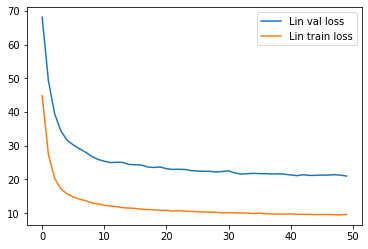

In [40]:
plt.plot(vl_lin2, label="Lin val loss")
plt.plot(tl_lin2, label="Lin train loss")
plt.legend()
plt.show()

In [42]:
for dna in ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_lin2(s.float())
    print(dna, pred)

AAAAAA tensor([11.7176], grad_fn=<AddBackward0>)
CCCCCC tensor([5.2495], grad_fn=<AddBackward0>)
GGGGGG tensor([0.4521], grad_fn=<AddBackward0>)
TTTTTT tensor([5.0028], grad_fn=<AddBackward0>)
AACCAA tensor([5.2514], grad_fn=<AddBackward0>)
CCGGGG tensor([0.3986], grad_fn=<AddBackward0>)
GGGTAA tensor([4.0127], grad_fn=<AddBackward0>)
TTTCGT tensor([3.2138], grad_fn=<AddBackward0>)
TGTAAT tensor([10.3386], grad_fn=<AddBackward0>)


In [44]:
for dna in :
    s = torch.tensor(one_hot_encode(dna))
    pred = model_lin2(s.float())
    print(dna, pred)
    
#     ('TATAAA', 14.9),
#     ('TAATAT', 14.8),
#     ('CCTATA', 14.5),
#     ('AAGCGA', 0.6),
#     ('GCGAAA', 0.7),
#     ('TTGCGA', 0.2),


TATAAA tensor([10.8625], grad_fn=<AddBackward0>)
TAATAT tensor([8.9638], grad_fn=<AddBackward0>)
CCTATA tensor([9.1524], grad_fn=<AddBackward0>)
AAGCGA tensor([3.5378], grad_fn=<AddBackward0>)
GCGAAA tensor([6.5253], grad_fn=<AddBackward0>)
TTGCGA tensor([-0.2992], grad_fn=<AddBackward0>)
GCGTAA tensor([3.7381], grad_fn=<AddBackward0>)
TATTAA tensor([8.0753], grad_fn=<AddBackward0>)
TTTATT tensor([7.7900], grad_fn=<AddBackward0>)


In [45]:
# class DNA_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv_net = nn.Sequential(
#             nn.Conv1d(4, 10, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(10,10, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.Sigmoid()) # ?? Linear?

#     def forward(self, xb):
#         xb = xb.view(-1,6,4) # reshape to 4x6
#         xb = self.conv_net(xb)
#         return xb
    
# class DNA_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv_net = nn.Sequential(
#             nn.Conv1d(4, 16, kernel_size=(3,1)),
#             nn.ReLU(inplace=True),
#             nn.Linear(96, 1)) # ?? Linear?

#     def forward(self, xb):
#         xb = xb.view(-1,6,4) # reshape to 4x6
#         xb = self.conv_net(xb)
#         return xb

class DNA_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) # ?? Linear?

    def forward(self, xb):
        xb = xb.view(-1,6,4).permute(0,2,1) # reshape to 4bs x 4channel x 6len
        #print(xb)
        xb = self.conv_net(xb)
        return xb
    
# class DNA_Linear(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lin = nn.Linear(24, 1)

#     def forward(self, xb):
#         # lin wraps up the weights/bias dot product from before
#         return self.lin(xb)

In [46]:
model_cnn = DNA_CNN()
loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=lr)
tl_cnn, vl_cnn = fit(50, model_cnn, loss_func, optimizer, train_dl, test_dl)

0 40.6715690612793
1 40.37783660888672
2 36.810550689697266
3 25.871519470214842
4 40.83929290771484
5 39.22800521850586
6 77.48642578125
7 27.12381362915039
8 18.393498992919923
9 17.6382194519043
10 20.524129486083986
11 21.57399215698242
12 12.914355850219726
13 11.953047943115234
14 15.0128662109375
15 12.581398391723633
16 11.565887451171875
17 6.693359756469727
18 7.235995483398438
19 7.864342117309571
20 5.465847778320312
21 7.203878021240234
22 4.886105346679687
23 4.112865829467774
24 4.8013715744018555
25 4.102758407592773
26 3.7902560234069824
27 3.8833343505859377
28 4.053083038330078
29 4.585363388061523
30 3.3617820739746094
31 3.3483532905578612
32 3.388096809387207
33 3.782131385803223
34 3.442391204833984
35 4.611374568939209
36 3.4518901824951174
37 2.7605968475341798
38 2.6472429990768434
39 2.632403039932251
40 2.490719938278198
41 2.4544651031494142
42 3.0625499725341796
43 2.4440274238586426
44 2.463066816329956
45 2.217893123626709
46 2.2091307163238527
47 2.5803

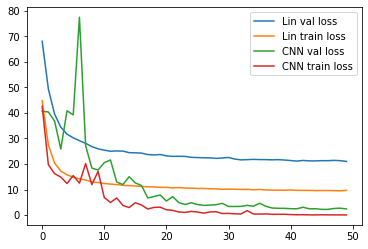

In [47]:
plt.plot(vl_lin2, label="Lin val loss")
plt.plot(tl_lin2, label="Lin train loss")
plt.plot(vl_cnn, label="CNN val loss")
plt.plot(tl_cnn, label="CNN train loss")
plt.legend()
plt.show()

In [48]:
for dna in ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_cnn(s.float())
    print(dna, pred)

AAAAAA tensor([[9.2661]], grad_fn=<AddmmBackward>)
CCCCCC tensor([[7.0220]], grad_fn=<AddmmBackward>)
GGGGGG tensor([[3.8047]], grad_fn=<AddmmBackward>)
TTTTTT tensor([[1.0482]], grad_fn=<AddmmBackward>)
AACCAA tensor([[4.8595]], grad_fn=<AddmmBackward>)
CCGGGG tensor([[3.0401]], grad_fn=<AddmmBackward>)
GGGTAA tensor([[8.0723]], grad_fn=<AddmmBackward>)
TTTCGT tensor([[1.2749]], grad_fn=<AddmmBackward>)
TGTAAT tensor([[12.7573]], grad_fn=<AddmmBackward>)


In [50]:
for dna in ['TATAAA', 'TAATAT','CCTATA','AAGCGA','GCGAAA','TTGCGA','GCGTAA', 'TATTAA','TTTATT']:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_cnn(s.float())
    print(dna, pred)
    
#     ('TATAAA', 14.9),
#     ('TAATAT', 14.8),
#     ('CCTATA', 14.5),
#     ('AAGCGA', 0.6),
#     ('GCGAAA', 0.7),
#     ('TTGCGA', 0.2),


TATAAA tensor([[15.1144]], grad_fn=<AddmmBackward>)
TAATAT tensor([[14.6269]], grad_fn=<AddmmBackward>)
CCTATA tensor([[11.5350]], grad_fn=<AddmmBackward>)
AAGCGA tensor([[0.4359]], grad_fn=<AddmmBackward>)
GCGAAA tensor([[1.0538]], grad_fn=<AddmmBackward>)
TTGCGA tensor([[0.3293]], grad_fn=<AddmmBackward>)
GCGTAA tensor([[3.9840]], grad_fn=<AddmmBackward>)
TATTAA tensor([[14.5705]], grad_fn=<AddmmBackward>)
TTTATT tensor([[13.7654]], grad_fn=<AddmmBackward>)


In [61]:
print(xb.view(-1,1,6,4))
print(xb.view(-1,6,4))

tensor([[[[1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.]]]], dtype=torch.float64)
tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0.

In [79]:
xb.view(-1,4)

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)

In [82]:
xb.shape

torch.Size([4, 24])

In [84]:
xb[0].shape

torch.Size([24])

In [89]:
xb.view(4,6,4)

tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]]], dtype=torch.float64)

In [91]:
xb.view(-1,6,4) == xb.view(4,6,4)

tensor([[[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]])

In [117]:
xb.view(4,4,6).shape

torch.Size([4, 4, 6])

In [124]:
xb.view(-1,6,4).permute(0,2,1)

tensor([[[1., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 1.],
         [1., 1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 1., 1.],
         [0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]], dtype=torch.float64)

In [125]:
xb.view(-1,6,4).permute(0,2,1).shape

torch.Size([4, 4, 6])

In [ ]:
xb = x_train[0:bs]  # a mini-batch from x
preds = model_lin(xb.float()) 